# Lid driven cavity using soft and hard boundary conditions using DeepXDE - Stationary case

I'll be testing new intervention in my code based on the Lid Driven cavity as a test bed, since i've already made it work once, if it stops working i'll know that the intervetion went bad. Will be using a square cavity of side $L$ and a lid speed of $U$ such that the flow still lamina. I'll initially only do the stationary case, and then do a second notebook to test the transient case.

In [144]:
from functools import partial

import torch
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np

torch.set_default_device("cuda:1")

# Setting parameters

I'll be setting the parameters only in this area of the notebook to make sure that all the tests share the same parameters.

In [156]:
L = 0.1   #  [m]
ρ = 100   #  [kg]/[m³]
μ = 0.001   #  [Pa][s]
U_top = 0.2  # [m]/[s]

Re = ρ*U_top*L/μ

print(f"{Re = }")

Re = 2000.0


# Dimensional Form

The first time it went right i was using the dimensional form. Therefore let's start by it before advancing to the non-dimensional form. Let's start by defining the differential equation as a function of inputs and outputs.

In [157]:
def pde_lid_driven_dimensional(X,Y):

    # 1st derivative
    du_x = dde.grad.jacobian(Y, X, i=0, j=0)
    du_y = dde.grad.jacobian(Y, X, i=0, j=1)
    dv_x = dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y = dde.grad.jacobian(Y, X, i=1, j=1)
    dp_x = dde.grad.jacobian(Y, X, i=2, j=0)
    dp_y = dde.grad.jacobian(Y, X, i=2, j=1)

    # 2nd derivatives
    du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)
    

    # Build equations
    pde_cont   = du_x + dv_y
    pde_u      = Y[:,0:1]*du_x +  Y[:,1:2]*du_y + dp_x/ρ - μ*(du_xx+ du_yy)
    pde_v      = Y[:,0:1]*dv_x +  Y[:,1:2]*dv_y + dp_y/ρ - μ*(dv_xx+ dv_yy)

    
    return [pde_u, pde_v, pde_cont]

Let's now define our domain and boundary conditions

In [158]:
## Let's go with a square for this case
geom = dde.geometry.Rectangle(xmin=(0, 0), xmax=(L, L))

def bottom_walls(X,on_boundary):
    return on_boundary and (not dde.utils.isclose(X[1], L))

def lid(X,on_boundary):
    return on_boundary and dde.utils.isclose(X[1], L)

def boundary_walls(X, on_boundary):
    return on_boundary

Let's test if our functions correctly captures the boundaries:

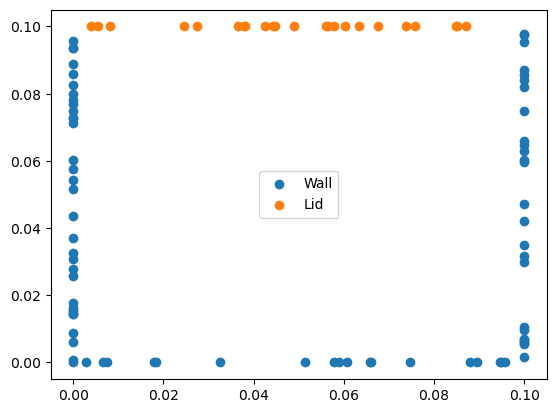

In [44]:
X = geom.random_boundary_points(100)


fwall = partial(bottom_walls, on_boundary=True)
flid = partial(lid, on_boundary=True)

mask = np.apply_along_axis(fwall, 1, X)
mask2 = np.apply_along_axis(flid, 1, X)

x, y = X.T

plt.scatter(x[mask], y[mask], label="Wall")
plt.scatter(x[mask2], y[mask2], label="Lid")

plt.legend()

Functions are correct, let's implement the boundary condition objects.

In [159]:
bc_wall_u     = dde.DirichletBC(geom, lambda x: 0, bottom_walls, component=0)
bc_wall_u_lid = dde.DirichletBC(geom, lambda x: U_top, lid, component=0)
bc_wall_v     = dde.DirichletBC(geom, lambda x: 0, boundary_walls, component=1)

soft_conditions = [
    bc_wall_u,
    bc_wall_u_lid,
    bc_wall_v
]

All set, lets now implement instantiate the model and training varaibles

In [175]:
net = dde.maps.FNN([2,] + [64]*6 + [3,], "silu", "Glorot uniform")

data = dde.data.PDE(
    geom,
    pde_lid_driven_dimensional,
    soft_conditions,
    num_boundary=1000,
    num_domain=2000,
    num_test=100,
)

model = dde.Model(data, net)

In [176]:
model.compile("adam", lr=0.001)

losshistory, train_state = model.train(47_000)


model.compile("L-BFGS")

model.train(3_000)

Compiling model...
'compile' took 0.000136 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.10e-09, 1.19e-09, 2.30e-06, 1.19e-09, 4.00e-02, 5.45e-08]    [1.10e-09, 1.19e-09, 2.30e-06, 1.19e-09, 4.00e-02, 5.45e-08]    []  
1000      [2.61e-04, 2.07e-06, 1.63e-06, 2.68e-03, 2.80e-04, 5.82e-04]    [3.01e-04, 1.83e-06, 1.87e-06, 2.68e-03, 2.80e-04, 5.82e-04]    []  
2000      [3.66e-05, 1.90e-05, 2.35e-07, 2.22e-03, 1.55e-04, 2.34e-04]    [3.57e-05, 1.19e-05, 2.66e-07, 2.22e-03, 1.55e-04, 2.34e-04]    []  
3000      [2.55e-05, 1.71e-05, 2.00e-07, 2.23e-03, 1.51e-04, 2.28e-04]    [2.60e-05, 1.08e-05, 1.74e-07, 2.23e-03, 1.51e-04, 2.28e-04]    []  
4000      [1.76e-05, 1.51e-05, 5.03e-06, 2.25e-03, 1.33e-04, 2.27e-04]    [1.98e-05, 9.64e-06, 4.23e-06, 2.25e-03, 1.33e-04, 2.27e-04]    []  
5000      [2.37e-05, 1.64e-05, 5.10e-06, 2.19e-03, 1.86e-04, 2.24e-04]

(<deepxde.model.LossHistory at 0x70c9446919d0>,
 <deepxde.model.TrainState at 0x70c8ab80d400>)

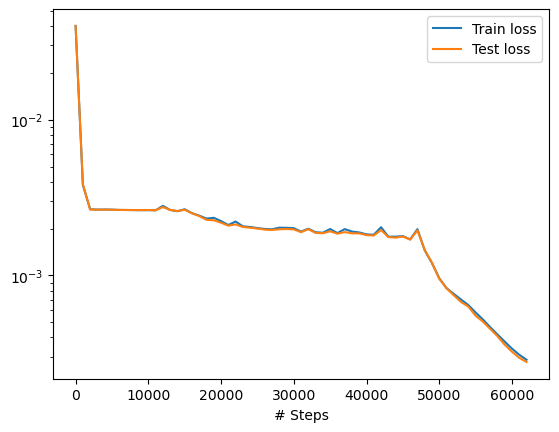

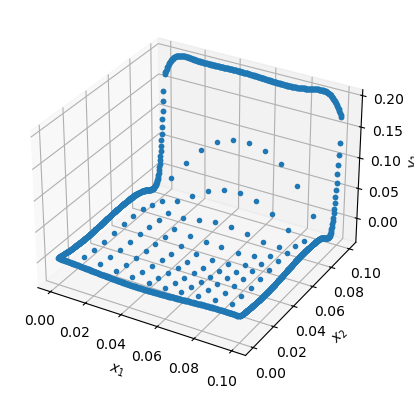

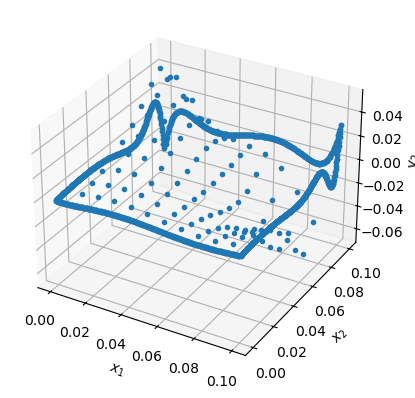

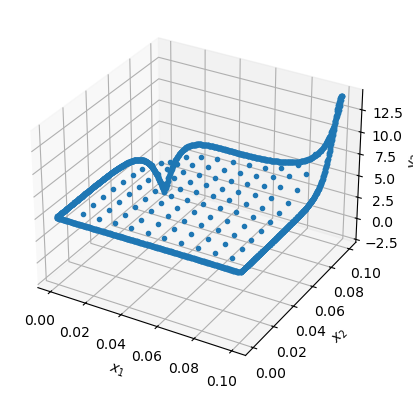

In [177]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

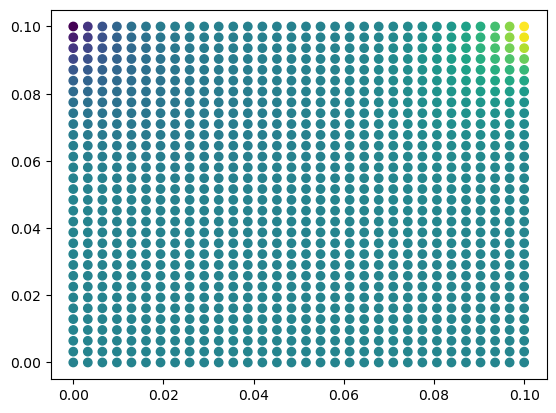

In [181]:
X = geom.uniform_points(1000)

x, y = X.T

u, v, p = model.predict(X).T

plt.scatter(x, y, c=p)

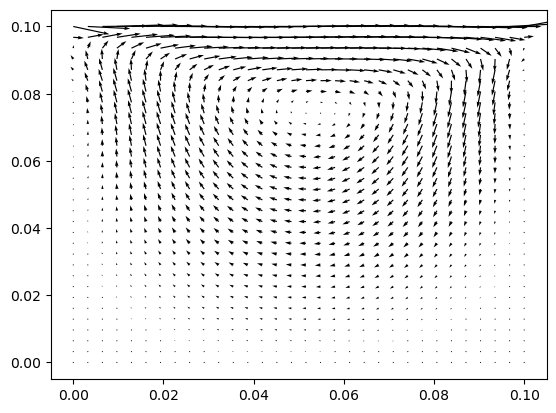

In [182]:
plt.quiver(x, y, u, v)

# Let's check for continuity

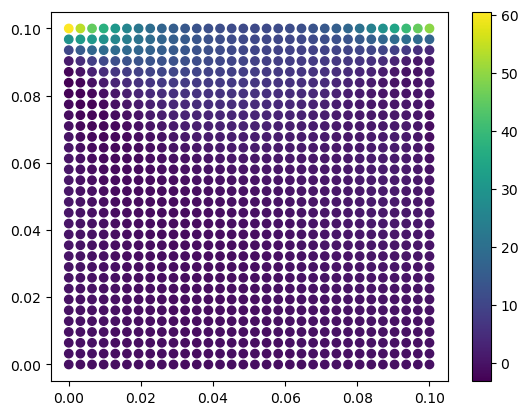

In [183]:

# Y = model.predict(torch.tensor(X, requires_grad=True))



X2 = torch.tensor(X).requires_grad_(True)
Y = model.net(X2)

du_x = dde.grad.jacobian(Y, X2, i=0, j=0)
du_y = dde.grad.jacobian(Y, X2, i=0, j=1)


cont = (du_x + du_y).detach().cpu().numpy()

plt.scatter(x, y, c=cont)
plt.colorbar()

Interestingly we got the same pattern of having the discontinuity broken on the corners just like on the numerical method when we don't use a pressure projetction equation ... I wonder what would happen if i put a pressure projection equation on it! For note it down for an experiment.  Let's now check if there is any advantage on using the non-dimensional form.

# Nondimensional form

For the non-dimensional form we will keep using almost the same infrastructure, only changing the geometry to represent the non-dimensional domain, and the PDE. Let's start by changing the PDE.

In [134]:
def pde_lid_driven_nondimensional(X,Y):
    """Nondimensional Boussinesq approximated NS equations"""
    
    du_x = dde.grad.jacobian(Y, X, i=0, j=0)
    du_y = dde.grad.jacobian(Y, X, i=0, j=1)
    dv_x = dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y = dde.grad.jacobian(Y, X, i=1, j=1)
    dp_x = dde.grad.jacobian(Y, X, i=2, j=0)
    dp_y = dde.grad.jacobian(Y, X, i=2, j=1)
    
    du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)
    

    pde_cont   = du_x + dv_y
    pde_u      = Y[:,0:1]*du_x +  Y[:,1:2]*du_y + (dp_x - (du_xx+ du_yy))/Re
    pde_v      = Y[:,0:1]*dv_x +  Y[:,1:2]*dv_y + (dp_y - (dv_xx+ dv_yy))/Re

    
    return [pde_u, pde_v, pde_cont]

The non-dimensionalization used is described on the master working folder in xjournal format. Now let's redefine the geometry and boundaries.

In [136]:
L = L/L

geom = dde.geometry.Rectangle(xmin=(0, 0), xmax=(L, L))

def bottom_walls(X,on_boundary):
    return on_boundary and (not dde.utils.isclose(X[1], L))

def lid(X,on_boundary):
    return on_boundary and dde.utils.isclose(X[1], L)

def boundary_walls(X, on_boundary):
    return on_boundary


bc_wall_u     = dde.DirichletBC(geom, lambda x: 0, bottom_walls, component=0)
bc_wall_u_lid = dde.DirichletBC(geom, lambda x: U_top, lid, component=0)
bc_wall_v     = dde.DirichletBC(geom, lambda x: 0, boundary_walls, component=1)

soft_conditions = [
    bc_wall_u,
    bc_wall_u_lid,
    bc_wall_v
]

Re-instantiate the network.

In [137]:
net = dde.maps.FNN([2,] + [64]*6 + [3,], "silu", "Glorot uniform")

data = dde.data.PDE(
    geom,
    pde_lid_driven_dimensional,
    soft_conditions,
    num_boundary=1000,
    num_domain=2000,
    num_test=100,
)

model = dde.Model(data, net)

In [138]:
model.compile("adam", lr=0.001)

losshistory, train_state = model.train(47_000)


model.compile("L-BFGS")

model.train(3_000)

Compiling model...
'compile' took 0.000183 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [7.64e-10, 3.01e-10, 4.33e-05, 6.81e-07, 4.06e-02, 1.39e-05]    [7.84e-10, 1.81e-10, 4.31e-05, 6.81e-07, 4.06e-02, 1.39e-05]    []  
1000      [5.65e-06, 7.61e-07, 9.98e-06, 8.94e-04, 5.65e-05, 2.03e-05]    [3.38e-06, 5.00e-07, 3.98e-06, 8.94e-04, 5.65e-05, 2.03e-05]    []  
2000      [8.33e-06, 3.62e-06, 8.66e-06, 5.58e-04, 5.66e-05, 2.01e-05]    [6.05e-06, 1.95e-06, 7.28e-06, 5.58e-04, 5.66e-05, 2.01e-05]    []  
3000      [6.76e-05, 5.07e-06, 8.04e-05, 4.20e-04, 3.42e-05, 1.79e-05]    [1.69e-05, 3.40e-06, 2.15e-05, 4.20e-04, 3.42e-05, 1.79e-05]    []  
4000      [3.02e-05, 7.42e-06, 1.62e-04, 3.76e-04, 6.71e-05, 6.66e-05]    [2.21e-05, 5.31e-06, 6.13e-05, 3.76e-04, 6.71e-05, 6.66e-05]    []  
5000      [4.66e-05, 8.78e-06, 1.00e-05, 3.12e-04, 7.31e-05, 3.85e-05]

(<deepxde.model.LossHistory at 0x70c9c4168ec0>,
 <deepxde.model.TrainState at 0x70c9ac31aa80>)

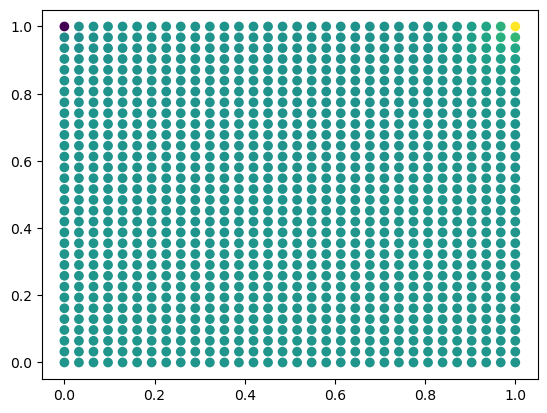

In [139]:
X = geom.uniform_points(1000)

x, y = X.T

u, v, p = model.predict(X).T

plt.scatter(x, y, c=p)

Looks like the defect on the corners got shaper! Let's see the vector plot!

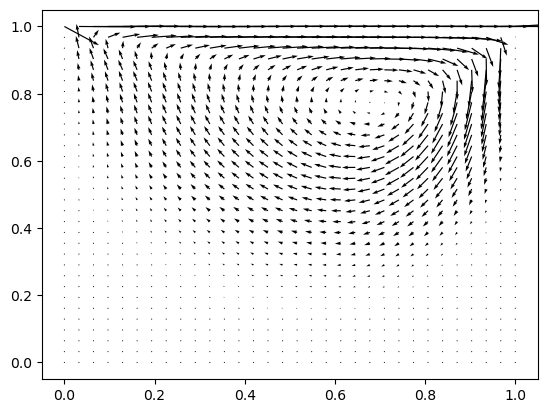

In [141]:
plt.quiver(x, y, u, v)

Funny ... for some reason the center of the vortex got moved! I'll check it quantitatively later to see what may have happen!

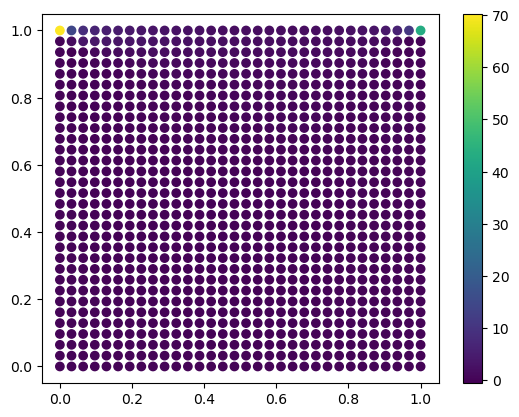

In [143]:

# Y = model.predict(torch.tensor(X, requires_grad=True))



X2 = torch.tensor(X).requires_grad_(True)
Y = model.net(X2)

du_x = dde.grad.jacobian(Y, X2, i=0, j=0)
du_y = dde.grad.jacobian(Y, X2, i=0, j=1)


cont = (du_x + du_y).detach().cpu().numpy()

plt.scatter(x, y, c=cont)
plt.colorbar()

Nonetheless the conservation plot looks also better! Let's check it numerically later! Now lets check how it behaves if we use a hard boundary.

# Hard boundary condition

In this session, lets apply a hard boundary where it is possible so that we make the manifold containing the solution smaller! Let's start by re-defining the geometry and boundary conditions. In this case will'

In [219]:
L = L/L

geom = dde.geometry.Rectangle(xmin=(0, 0), xmax=(L, L))

def bottom_walls(X,on_boundary):
    return on_boundary and (not dde.utils.isclose(X[1], L))

def lid(X,on_boundary):
    return on_boundary and dde.utils.isclose(X[1], L)

def boundary_walls(X, on_boundary):
    return on_boundary


bc_wall_u     = dde.DirichletBC(geom, lambda x: 0, bottom_walls, component=0)
bc_wall_u_lid = dde.DirichletBC(geom, lambda x: U_top, lid, component=0)
# bc_wall_v     = dde.DirichletBC(geom, lambda x: 0, boundary_walls, component=1)

soft_conditions = [
    bc_wall_u,
    bc_wall_u_lid,
    # bc_wall_v
]

Now let's set the transform and instantiate the new network.

In [220]:
def transform(X, Y):
    """Ansatz to make the spped exactly zero on the boundaries in the y component"""
    noslip_ansatz_factor = X[:, 0:1] * (L - X[:, 0:1]) * X[:, 1:2] * (L - X[:, 1:2])

    return torch.hstack(
        (
            Y[:, 0:1],
            noslip_ansatz_factor*Y[:, 1:2],
            Y[:, 2:]
        )
    )

net = dde.maps.FNN([2,] + [64]*6 + [3,], "silu", "Glorot uniform")
net.apply_output_transform(transform)

data = dde.data.PDE(
    geom,
    pde_lid_driven_nondimensional,
    soft_conditions,
    num_boundary=1000,
    num_domain=2000,
    num_test=100,
)

model = dde.Model(data, net)

Now let's go with the training!

In [221]:
model.compile("adam", lr=0.001)

losshistory, train_state = model.train(40_000)


model.compile("L-BFGS")

losshistory, train_state = model.train(10_000)

Compiling model...
'compile' took 0.000167 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [1.14e-12, 2.51e-11, 1.98e-06, 7.12e-07, 4.04e-02]    [8.85e-13, 2.84e-11, 2.28e-06, 7.12e-07, 4.04e-02]    []  
1000      [7.50e-06, 8.24e-09, 1.61e-05, 9.62e-04, 3.16e-05]    [3.08e-06, 5.12e-09, 2.60e-06, 9.62e-04, 3.16e-05]    []  
2000      [3.50e-05, 8.77e-08, 1.15e-05, 5.75e-04, 5.77e-06]    [7.97e-06, 5.34e-08, 3.76e-06, 5.75e-04, 5.77e-06]    []  
3000      [7.17e-05, 7.86e-07, 7.89e-06, 4.24e-04, 5.93e-06]    [1.14e-05, 3.66e-07, 2.19e-06, 4.24e-04, 5.93e-06]    []  
4000      [6.07e-05, 1.17e-05, 6.06e-06, 3.82e-04, 7.01e-06]    [1.86e-05, 6.52e-06, 4.80e-07, 3.82e-04, 7.01e-06]    []  
5000      [6.46e-05, 1.39e-05, 5.61e-06, 3.41e-04, 1.32e-05]    [2.29e-05, 9.55e-06, 2.75e-07, 3.41e-04, 1.32e-05]    []  
6000      [6.12e-05, 1.40e-05, 5.72e-06, 3.23e-04, 1.12e-05]    [2.

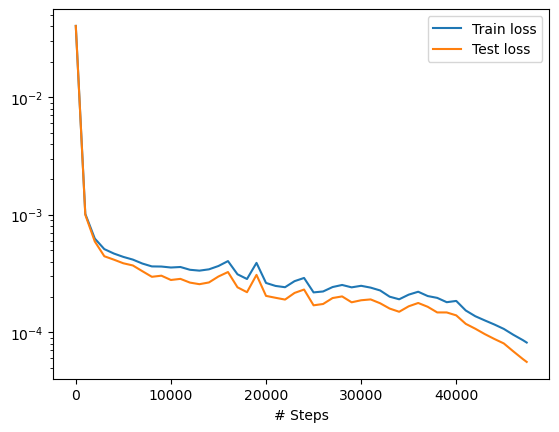

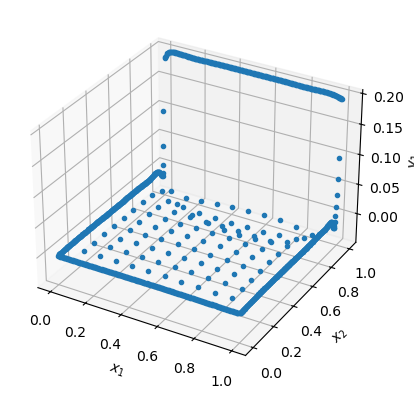

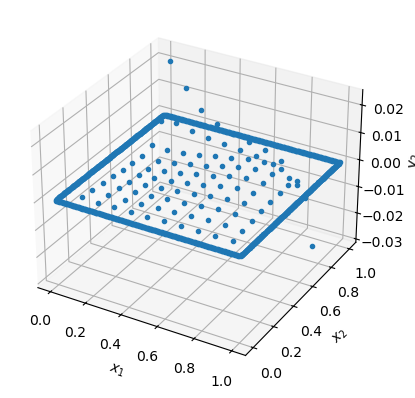

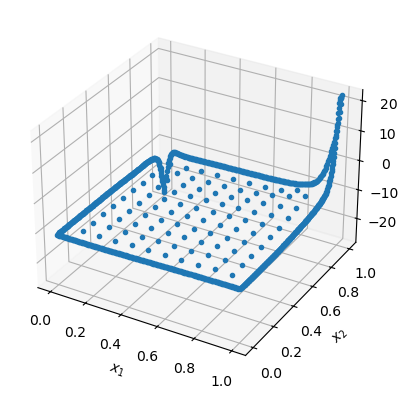

In [222]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

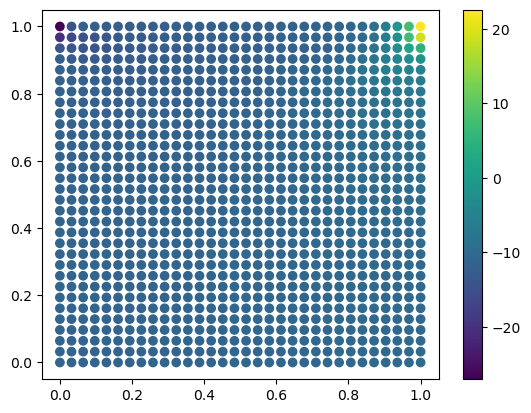

In [224]:
X = geom.uniform_points(1000)

x, y = X.T

u, v, p = model.predict(X).T

plt.scatter(x, y, c=p)
plt.colorbar()

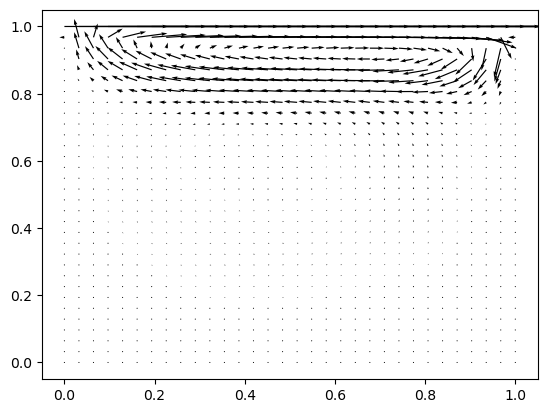

In [225]:
plt.quiver(x, y, u, v)

This is funny ... The results i'm getting are different of the 

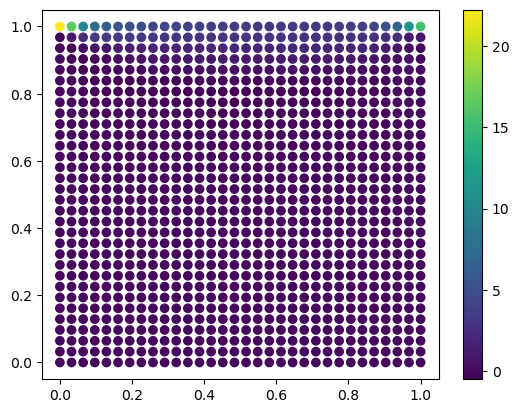

In [226]:

# Y = model.predict(torch.tensor(X, requires_grad=True))



X2 = torch.tensor(X).requires_grad_(True)
Y = model.net(X2)

du_x = dde.grad.jacobian(Y, X2, i=0, j=0)
du_y = dde.grad.jacobian(Y, X2, i=0, j=1)


cont = (du_x + du_y).detach().cpu().numpy()

plt.scatter(x, y, c=cont)
plt.colorbar()

# Numerical verification

Now i'll simulate this system using OpenFOAM then open it here to compare the results from each type of neural network to see which one is giving the best result numerically!